In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from plotnine import *
pd.options.mode.chained_assignment = None  # default='warn'

The United States National Hurricane Center defines **rapid intensification as an increase in the maximum sustained winds of a tropical cyclone of at least 30 knots in a 24-hour period.**

### Read in data from official HURDAT2.csv file

In [2]:
def read_hurdat_lines():
    f = open("data/HURDAT2.csv", "r")
    lines = f.readlines()
    f.close()
    return lines

In [3]:
def hurdat_lines_to_df(lines):
    hurdat=[]
    storm_info=[]
    df = pd.DataFrame()
    for line in lines:
        arr = line.split(",")
        if "AL" in arr[0]:
            storm_info = [arr[0],arr[1].strip()]
        else:
            arr.insert(0,storm_info[0])
            arr.insert(1,storm_info[1])
            hurdat.append(arr)
    df = pd.DataFrame(hurdat)
    return df

### Prettify the Dataframe (Cut, Rename, Strip, Retype)

In [4]:
def cut_and_rename_columns(df):
    df = df.iloc[:,:10]
    col_names = {
        df.columns[0]: 'Code',df.columns[1]: 'Name',  df.columns[2]: 'Date',
        df.columns[3]: 'Time', df.columns[4]: 'Record',df.columns[5]: 'Status',
        df.columns[6]: 'Lat',  df.columns[7]: 'Lon',   df.columns[8]: 'Wind',
        df.columns[9]: 'Pressure'
    }
    df = df.rename(columns = col_names)
    return df

In [5]:
def strip_string_columns(df):
    df_obj = df.select_dtypes(['object'])
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    return df

In [6]:
def create_datetime_column(df):
    df["DateTime"] = df["Date"] + ' ' + df["Time"]
    df["DateTime"] = pd.to_datetime(df["DateTime"], format = '%Y%m%d %H%M')
    df = df.drop(columns=['Date', 'Time'], axis=1)
    return df

In [7]:
def create_seperate_date_columns(df):
    df["Date"] = pd.to_datetime(df["Date"], infer_datetime_format=True)
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    return df

In [8]:
def convert_columns_to_integer(df, cols):
    df[cols] = df[cols].astype(str).astype(int)
    return df

### Convert coordinates from string (19.7W) to float (-19.7)

In [9]:
def convert_coordinates(df):
    for direc in ['Lat','Lon']:
        df[f'{direc}_Hemisphere'] = df[f'{direc}'].str[-1:]
        df[f'{direc}'] = df[f'{direc}'].str[:-1].astype(float)
        
        convert_direc = lambda row: row[f"{direc}"]*-1 if row[f"{direc}_Hemisphere"] in ['S','W'] else row[f"{direc}"]
        
        df[f'{direc}'] = df.apply(convert_direc, axis=1)
        df = df.drop(columns=[f"{direc}_Hemisphere"])
    return df

### Create 'Rapid_NHC24' column denoting if storm was 'Rapid Increasing' (per NHC definition)

In [10]:
def within_24_hours(time, series):
    return (time-timedelta(hours=24) <= series) & (series <= time) 

In [11]:
def get_progress(i,n,t):
    if i%(n//t) == 0: 
        print(round(i/n,1))

In [12]:
def create_rapid_NHC_column(df):
    df["Rapid_NHC24"] = False
    storm_codes = df.Code.unique()
    for index_storm, storm in enumerate(storm_codes):
        get_progress(index_storm,len(storm_codes),10)
        df_storm = df[df.Code == storm]
        for index_row, row in df_storm.iterrows():
            current_time = row['DateTime']
            current_wind = row["Wind"]
            df_24_hours = df_storm[ within_24_hours(current_time, df_storm['DateTime']) ]
            min_wind_24_hours = df_24_hours["Wind"].min()
            df.loc[index_row,"Rapid_NHC24"] = (current_wind - min_wind_24_hours ) > 30
    return df

### Create 'Rapid_NHC{k}' column denoting if storm was Rapid Increasing, defined as an increase of 30 knots in Maximum Sustained Windspeed over the previous k hours

In [13]:
def within_k_hours(time, series, k):
    return (time-timedelta(hours=k) <= series) & (series <= time) 

In [14]:
def create_k_rapid_NHC_column(df, k):
    df[f"Rapid_NHC{k}"] = False
    storm_codes = df.Code.unique()
    for index_storm, storm in enumerate(storm_codes):
        get_progress(index_storm,len(storm_codes),10)
        df_storm = df[df.Code == storm]
        for index_row, row in df_storm.iterrows():
            current_time = row['DateTime']
            current_wind = row["Wind"]
            df_k_hours = df_storm[ within_k_hours(current_time, df_storm['DateTime'], k) ]
            min_wind_k_hours = df_k_hours["Wind"].min()
            df.loc[index_row,f"Rapid_NHC{k}"] = (current_wind - min_wind_k_hours ) > 30
    return df

### Acceleration

In [15]:
def create_acceleration_column(df):
    df[f"Accel"] = 0
    storm_codes = df.Code.unique()
    for index_storm, storm in enumerate(storm_codes):
        get_progress(index_storm,len(storm_codes),10)
        df_storm = df[df.Code == storm]
        current_wind, previous_wind = 0, 0
        first_index = 999999;
        for index_row, row in df_storm.iterrows():
            if index_row < first_index: first_index = index_row
            try:
                current_wind = df.iloc[index_row]['Wind']
            except:
                print(index_row)
            try:
                previous_wind = df.iloc[index_row-1]['Wind']
                delta_wind = current_wind - previous_wind
            except:
                delta_wind = 0
            df.loc[index_row,'Accel'] = delta_wind
        df.loc[first_index,'Accel'] = 0
        first_index = 999999;
    return df

### Remove storms that do not reach Category X

In [16]:
def remove_storms_below_cat_X(df, X):
    cat_X_minimum_wind_speeds = {1:64 , 2:83, 3:96, 4:113, 5:137}
    df = df[(df.groupby('Code')['Wind'].transform('max')) >= cat_X_minimum_wind_speeds[X]]
    return df

In [17]:
lines = read_hurdat_lines()
df = hurdat_lines_to_df(lines)

In [18]:
df = cut_and_rename_columns(df)
df = strip_string_columns(df)
df = create_datetime_column(df)
#df = create_seperate_date_columns(df)
df = convert_columns_to_integer(df, ['Wind','Pressure'])

df = convert_coordinates(df)

df = remove_storms_below_cat_X(df,1)
df = df.reset_index(drop=True)

In [20]:
df = create_k_rapid_NHC_column(df,6)
df = create_k_rapid_NHC_column(df,12)
df = create_k_rapid_NHC_column(df,24)
df = create_acceleration_column(df)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


In [30]:
df.to_pickle("cat1_and_above.pkl")

In [22]:
df = pd.read_pickle("cat1_and_above.pkl")

### Write to .text file for R visualization

In [23]:
storm_codes = df.Code.unique()
f = open('hurdaddy.csv',"w")
f.write(f"code,year,lat_1,lon_1,lat_2,lon_2,wind,pressure,Rapid_NHC24,Rapid_NHC12,Rapid_NHC6,Accel,col,alph,siz,\n")
for storm_index, storm in enumerate(storm_codes):
    get_progress(storm_index,len(storm_codes),10)
    df_storm = df[df.Code == storm ]
    for i in range(len(df_storm)-1):
        Code = df_storm.iloc[i,:].Code
        Year = df_storm.iloc[i,:].DateTime.year
        Lat1 = df_storm.iloc[i,:].Lat
        Lon1 = df_storm.iloc[i,:].Lon
        Lat2 = df_storm.iloc[i+1,:].Lat
        Lon2 = df_storm.iloc[i+1,:].Lon
        Wind = df_storm.iloc[i,:].Wind
        R1 = df_storm.iloc[i,:].Rapid_NHC24
        R2 = df_storm.iloc[i,:].Rapid_NHC12
        R3 = df_storm.iloc[i,:].Rapid_NHC6
        Accel = df_storm.iloc[i,:].Accel
        Pressure = df_storm.iloc[i,:].Pressure
        f.write(f"{Code},{Year},{Lat1},{Lon1},{Lat2},{Lon2},{Wind},{Pressure},{R1},{R2},{R3},{Accel},white,0.2,0.2,\n")
f.close()

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


### R cell magic

In [24]:
%load_ext rpy2.ipython

In [31]:
%%R
library(ggmap)
library(ggplot2)
library(tidyverse)
library(dplyr)
library(repr)

In [80]:
%%R
mydf = read.csv('hurdaddy.csv')
map <- get_map(location = c(left = -105, bottom = 10,
                            right = -60, top = 40),
               source="stamen", maptype="terrain")
mydf = mydf %>% filter(year == 2020)

In [59]:
%%R
mydf[mydf$Rapid_NHC24 == 'True',]['col'] = 'red'
mydf[mydf$Rapid_NHC12 == 'True',]['col'] = 'purple'
mydf[mydf$Rapid_NHC24 == 'True',]['siz'] = 3
mydf[mydf$Rapid_NHC12 == 'True',]['siz'] = 3

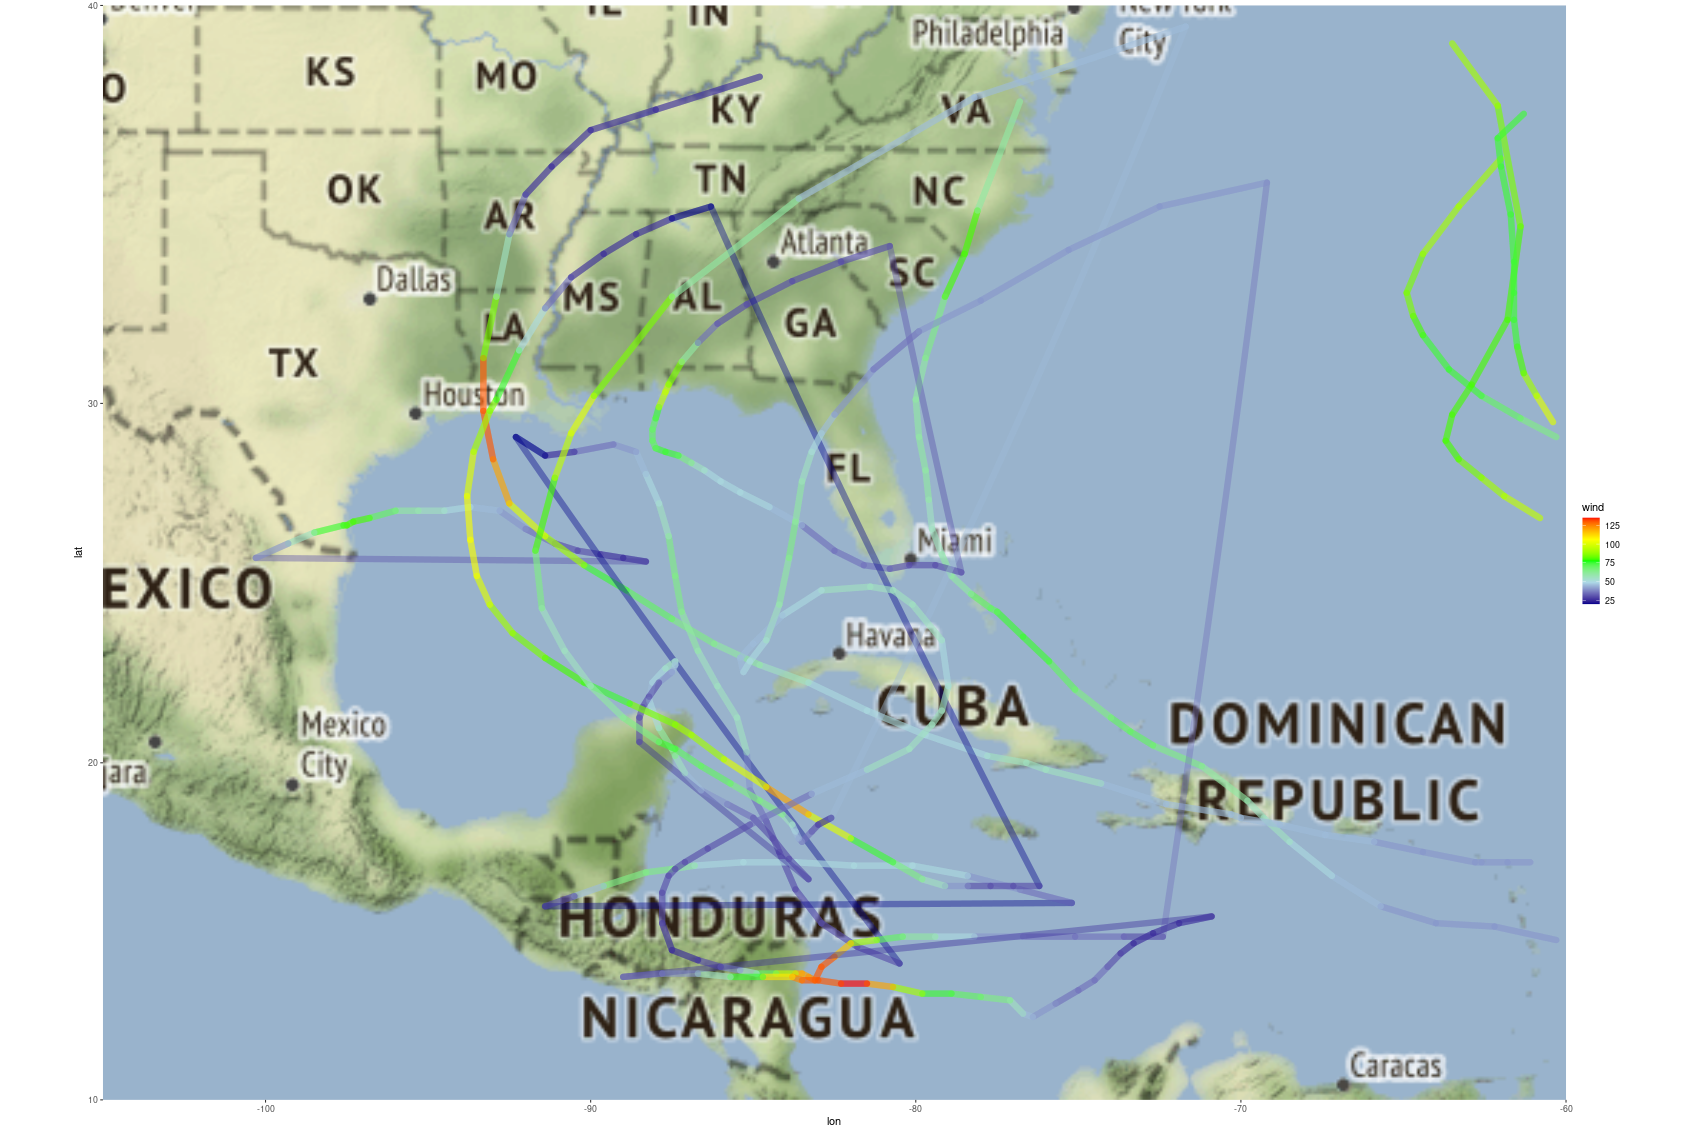

In [81]:
%%R -w 60 -h 40 -u cm
ggmap(map) + 
geom_segment(data = mydf,
             aes(x = lon_1, y = lat_1, xend = lon_2, yend = lat_2, color=wind),  
             size = 3, 
             alpha = 2*mydf$alph, 
             lineend = "round")+
scale_colour_gradientn(colours = c("red","yellow","green","lightblue","darkblue"),
                         values = c(1.0,0.8,0.6,0.4,0.2,0)) 